# GPU-libraries
Processing large amounts of data, e.g. stored in arrays, can be computational costly. To accelerate processing, graphics processing units (GPUs) can be exploited, for example using [NVidia Compute Unified Device Architecture (CUDA)](https://en.wikipedia.org/wiki/CUDA) and the [Open Computing Language (OpenCL)](https://www.khronos.org/opencl/). For processing images with CUDA, there are a couple of libraries available. We will take a closer look at [cupy](https://cupy.dev/), which brings more general computing capabilities for CUDA compatible GPUs. Furthermore, we will take a look at [pyopencl](https://documen.tician.de/pyopencl/) and [py-clEsperanto](https://github.com/clEsperanto/pyclesperanto_prototype).

See also
* [StackOverflow: Is it possible to install cupy on google colab?](https://stackoverflow.com/questions/49135065/is-it-possible-to-install-cupy-on-google-colab)
* [Tutorial: OpenCL SGEMM tuning for Kepler](https://cnugteren.github.io/tutorial/pages/page1.html)

Before we start, we need to install cupy, pyopencl and pyclesperanto it properly. The following commands make this notebook run in Google Colab.

!curl https://colab.chainer.org/install | sh -

!pip install scipy scikit-image cupy-cuda100

In [16]:
!pip install scipy scikit-image

!pip install cupy-cuda100

!pip install pyopencl

!pip install pyclesperanto_prototype

# Scenario: Matrix multiplication
As example scenario, we want to multiply two matrices.

In [1]:
import numpy as np

# create to arrays
np_a = np.random.random([10000,50])
np_b = np.random.random([50,10000])

np_c = np.matmul(np_a, np_b)
np_c.shape

(10000, 10000)

[Cupy](https://cupy.dev/) is a python library for GPU-accelerated computing using [CUDA](https://en.wikipedia.org/wiki/CUDA). Its application programming interface (API) aims being compatible with the numpy API. Thus, the commands should work the same. We just need to convert our numpy arrays into cupy arrays first.

In [ ]:
import cupy as cp

# transfer data to GPU memory
cp_a = cp.asarray(np_a)
cp_b = cp.asarray(np_b)

cp_c = cp.matmul(cp_a, cp_b)
cp_c.shape

## pyopencl
[pyopencl](https://documen.tician.de/pyopencl/) is a python library for GPU-accelerated scientific computing based on the [Open Computing Language](https://www.khronos.org/opencl/).

In [2]:
import pyopencl as cl
import pyopencl.array as cla

# initialize GPU driver and create a queue for running operations.
context = cl.create_some_context()
queue = cl.CommandQueue(context)

# copy data to GPU memory
cl_a = cla.to_device(queue, np.asarray([[1, 2, 3]]))
cl_b = cla.to_device(queue, np.asarray([[4, 4, 5]]))  

# execute operations on the data
cl_c = cl_a + cl_b

# show result
cl_c

cl.Array([[5, 6, 8]])

Thus, simple mathematical operations are supported in pyopencl, furthemore one can implement more complex operations by providing OpenCL-code. The following example executes the same operation as above but using custom OpenCL code.

In [3]:
cl_d = cla.empty_like(cl_a)

program = cl.Program(context, """
__kernel void sum(__global const float *a, __global const float *b, __global float *c)
{
  int i = get_global_id(1);
  c[i] = a[i] + b[i];
}""").build()

program.sum(queue, cl_a.shape, None, cl_a.data, cl_b.data, cl_d.data)

print(cl_d)

[[5 6 8]]


## pyclesperanto
As implementing custom OpenCL code for operations such as matrix multiplication is a bit cumbersome, other libraries such as [pyclesperanto](https://github.com/clEsperanto/pyclesperanto_prototype) ship with OpenCL code for such common operations.

In [4]:
import pyclesperanto_prototype as cle

# to measure kernel execution duration properly, we need to set this flag. It will slow down exection of workflows a bit though
cle.set_wait_for_kernel_finish(True)

cle.select_device("RTX")

<NVIDIA GeForce RTX 3050 Ti Laptop GPU on Platform: NVIDIA CUDA (1 refs)>

In [5]:
cl_c = cle.multiply_matrix(np_a, np_b)
cl_c.shape

(10000, 10000)

As good scientists, we should also check if the results of numpy `np_c`, cupy `cp_c` and clesperanto `cl_c` are the same. Therefore we check if the results of the two GPU libraries are close to the result of numpy as reference.

In [ ]:
print(np.allclose(np_c, cp_c))
print(np.allclose(np_c, cl_c))

## Benchmarking
We now know how to multiply matrices using numpy, cupy and clesperanto. To figure out which of the approaches is the most efficient, we should measure time passing by while executing these operations. We execute them multiple times to avoid misinterpreting individual time measurements influenced by stochastical variation and effects such as the warm-up effect. The warm-up effect results from just-in-time compilation. Some libraries compile device dependent code before running operations. This is only done once and costs some additional time while the first execution of an operation.

In [6]:
import time

In [7]:
for i in range(0, 3):
    start_time = time.time()
    
    np_c = np.matmul(np_a, np_b)
    
    print("Matrix multiplication took " + str(time.time() - start_time) + " s using numpy")

Matrix multiplication took 0.2430555820465088 s using numpy
Matrix multiplication took 0.2450554370880127 s using numpy
Matrix multiplication took 0.2438063621520996 s using numpy


In [ ]:
for i in range(0, 3):
    cp_a = cp.asarray(np_a)
    cp_b = cp.asarray(np_b)
    
    start_time = time.time()
    
    cp_c = cp.matmul(cp_a, cp_b)
    
    cupy.cuda.stream.get_current_stream().synchronize() # we need to wait here to measure time properly
    
    print("Matrix multiplication took " + str(time.time() - start_time) + " s using cupy")
    

In [8]:
for i in range(0, 3):
   
    start_time = time.time()
    
    cl_c = cle.multiply_matrix(np_a, np_b)
    
    print("Matrix multiplication took " + str(time.time() - start_time) + " s using clesperanto")

Matrix multiplication took 0.1200263500213623 s using clesperanto
Matrix multiplication took 0.1215360164642334 s using clesperanto
Matrix multiplication took 0.12026429176330566 s using clesperanto


GPU-accelerated code can perform faster if you avoid allocating memory, especially in loops. Furthermore, if memory transfer to GPU can be avoided, that's an additional plus. In the following example, we transfer the data to the GPU before the loop and for the result-output, we store the data in the same memory block after the first execution.

In [10]:
cl_a = cle.asarray(np_a)
cl_b = cle.asarray(np_b)
cl_c = None

for i in range(0, 3):
   
    start_time = time.time()
    
    cl_c = cle.multiply_matrix(cl_a, cl_b, cl_c)
    
    print("Matrix multiplication took " + str(time.time() - start_time) + " s using clesperanto")

Matrix multiplication took 0.11375856399536133 s using clesperanto
Matrix multiplication took 0.08802008628845215 s using clesperanto
Matrix multiplication took 0.08801603317260742 s using clesperanto


## Image processing
In image processing, we typically deal with large matrices, a.k.a. images. In the life sciences, we often work with three dimensional images. Thus, the utility of GPU-acceleration for 3D image processing is obvious.
In the following example, we will process a three dimensional image to segment cells. This involves algorithms such as thresholding, watershed and connected component labeling.

In [11]:
from skimage.data import cells3d

stack = cells3d()

In [12]:
stack.shape

(60, 2, 256, 256)

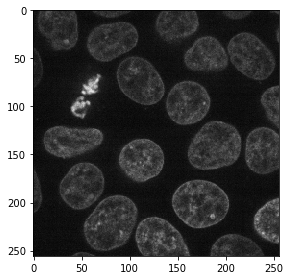

In [13]:
from skimage.io import imshow

imshow(stack[30, 1, :, :])

In [14]:
single_channel = stack[:, 1, :, :]
single_channel.shape

(60, 256, 256)

<ipython-input-25-98a7a69c285d>:14: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxima = skimage.feature.peak_local_max(
C:\Users\rober\miniconda3\envs\bio2\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


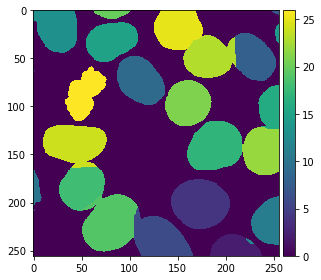

In [25]:
import skimage
from skimage import filters, segmentation

def np_segment_nuclei(nuclei_image):
  input_image = nuclei_image

  # binarize all nuclei together
  outline_blurred = skimage.filters.gaussian(input_image, sigma=2)
  threshold = skimage.filters.threshold_otsu(outline_blurred)
  binary = outline_blurred > threshold

  # estimate centroids
  spot_blurred = skimage.filters.gaussian(input_image, sigma=10)
  local_maxima = skimage.feature.peak_local_max(
      spot_blurred, 
      footprint=np.ones((3, 3, 3), dtype=np.bool), 
      indices=False, 
      labels=skimage.measure.label(binary)
  )

  # flood the binary image starting at the centroids
  markers = skimage.measure.label(local_maxima)
  labels = skimage.segmentation.watershed(-spot_blurred, markers, mask=binary)
  
  return labels

nuclei = np_segment_nuclei(single_channel)
imshow(nuclei.max(axis=0))

# CUDA

In [27]:
import cupy

ImportError: CuPy is not correctly installed.

If you are using wheel distribution (cupy-cudaXX), make sure that the version of CuPy you installed matches with the version of CUDA on your host.
Also, confirm that only one CuPy package is installed:
  $ pip freeze

If you are building CuPy from source, please check your environment, uninstall CuPy and reinstall it with:
  $ pip install cupy --no-cache-dir -vvvv

Check the Installation Guide for details:
  https://docs.cupy.dev/en/latest/install.html

original error: DLL load failed while importing runtime: The specified module could not be found.

In [ ]:
import cucim.skimage as cuskimage

def cu_segment_nuclei(nuclei_image):
  # send image to GPU
  input_image = cupy.asarray(nuclei_image)

  # binarize all nuclei together
  outline_blurred = cuskimage.filters.gaussian(input_image, sigma=2)
  threshold = cuskimage.filters.threshold_otsu(outline_blurred)
  binary = outline_blurred > threshold

  # estimate centroids
  spot_blurred = cuskimage.filters.gaussian(input_image, sigma=10)
  local_maxima = cuskimage.feature.peak_local_max(
      spot_blurred, 
      footprint=np.ones((3, 3, 3), dtype=np.bool), 
      indices=False, 
      labels=cuskimage.measure.label(binary)
  )

  # flood the binary image starting at the centroids
  markers = cuskimage.measure.label(local_maxima)
  labels = cuskimage.segmentation.watershed(-spot_blurred, markers, mask=binary)
  
  return np.asarray(labels)

nuclei = cu_segment_nuclei(single_channel)
imshow(nuclei.max(axis=0))

## pyclesperanto

In [20]:
import pyclesperanto_prototype as cle
cle.get_device()

<NVIDIA GeForce RTX 3050 Ti Laptop GPU on Platform: NVIDIA CUDA (2 refs)>

C:\Users\rober\miniconda3\envs\bio2\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


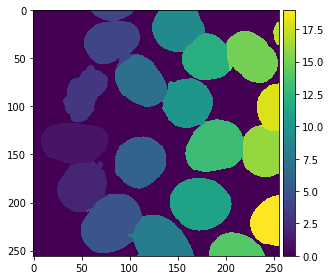

In [21]:
def cl_segment_nuclei(nuclei_image):
  input_image = nuclei_image

  # binarize all nuclei together
  outline_blurred = cle.gaussian_blur(input_image, sigma_x=2, sigma_y=2, sigma_z=2)
  binary = cle.threshold_otsu(outline_blurred)
  
  # estimate centroids
  spot_blurred = cle.gaussian_blur(input_image, sigma_x=10, sigma_y=10, sigma_z=10)
  local_maxima = cle.detect_maxima_box(spot_blurred, radius_x=1, radius_y=1, radius_z=1)

  # flood the binary image starting at the centroids
  labels = cle.masked_voronoi_labeling(local_maxima, binary)
  
  return labels

nuclei = cl_segment_nuclei(single_channel)
imshow(nuclei.max(axis=0))

As clesperanto is developed by life scientists, there is a method built-in doing pretty much the same as shown above: [Voronoi-Otsu-Labeling](https://nbviewer.jupyter.org/github/clEsperanto/pyclesperanto_prototype/tree/master/demo/segmentation/voronoi_otsu_labeling.ipynb).

C:\Users\rober\miniconda3\envs\bio2\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


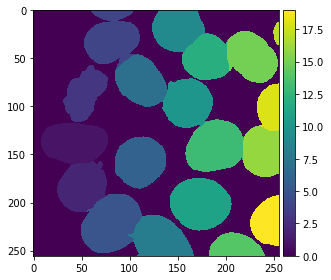

In [23]:

nuclei = cle.voronoi_otsu_labeling(single_channel, spot_sigma=10, outline_sigma=2)

imshow(nuclei.max(axis=0))

## Benchmarking
As mentioned above, we will benchmark those algorithms to compare performance.

In [26]:
for i in range(0, 3):
    start_time = time.time()
    
    nuclei = np_segment_nuclei(single_channel)
    
    print("Nuclei segmentation took " + str(time.time() - start_time) + " s using numpy")

<ipython-input-25-98a7a69c285d>:14: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxima = skimage.feature.peak_local_max(


Nuclei segmentation took 1.0597450733184814 s using numpy
Nuclei segmentation took 1.0552396774291992 s using numpy
Nuclei segmentation took 1.0459222793579102 s using numpy


In [24]:
for i in range(0, 3):
   
    start_time = time.time()
    
    nuclei = cl_segment_nuclei(single_channel)
    
    print("Nuclei segmentation took " + str(time.time() - start_time) + " s using clesperanto")

Nuclei segmentation took 0.19744658470153809 s using clesperanto
Nuclei segmentation took 0.19676518440246582 s using clesperanto
Nuclei segmentation took 0.19615674018859863 s using clesperanto
